In [25]:
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [26]:
cmap = plt.cm.tab20

In [27]:
beno_mem = np.load('beno.npy')

states_list = beno_mem[:,0]
actions = np.array(beno_mem[:,1])
rewards = np.array(beno_mem[:,2::24])

states = np.array([np.array(x) for x in states_list])

batt = states[:,0]
enp = states[:,1]
henergy = states[:,2]
fcast = states[:,3]

In [28]:
#cumulative downtimes and overflows

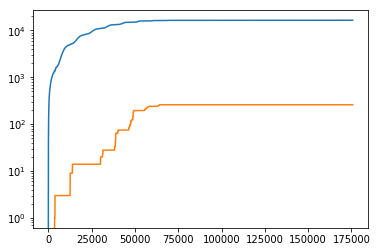

In [29]:
downtime = (batt <= 0.005).sum()
overflows = (batt == 1).sum()

downtime_mask = (batt <= 0.005)
overflow_mask = (batt ==1)

downtime_occur = (batt <= 0.005).astype(int)
overflow_occur = (batt == 1).astype(int)

cum_downtime = downtime_occur.cumsum()
cum_overflow = overflow_occur.cumsum()

plt.plot(cum_downtime)
plt.plot(cum_overflow)
plt.yscale('log')

In [30]:
# moving average of battery and enp

In [31]:
def moving_average(a, n=30) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

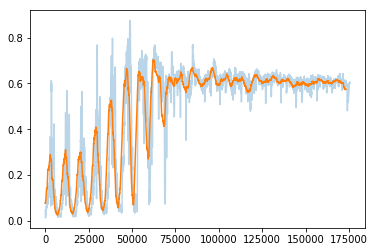

In [32]:
plt.plot(moving_average(batt,240),alpha=0.3)
plt.plot(moving_average(batt,2400))

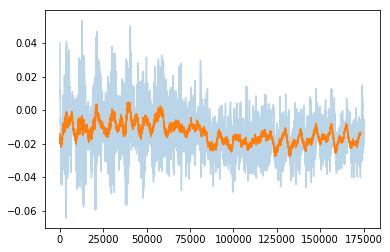

In [33]:
plt.plot(moving_average(enp,240),alpha=0.3)
plt.plot(moving_average(enp,2400))

In [47]:
batt_sorted_actions = np.array([batt[actions==i] for i in range(10)])

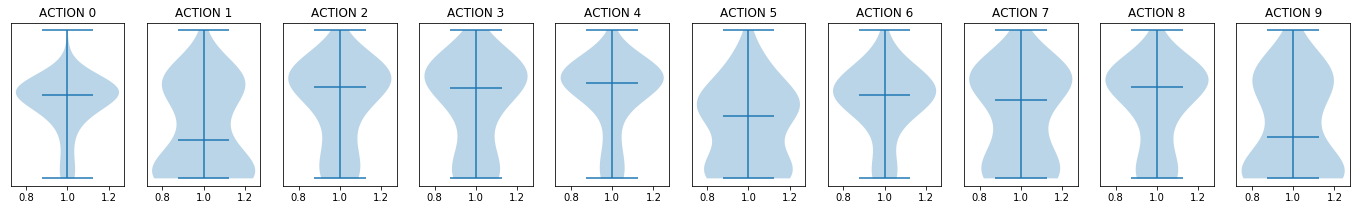

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(24, 3))

for i in range(10):
    ax = axes[i]
    ax.violinplot(batt_sorted_actions[i], widths=0.5, bw_method=0.5, showmedians=True)
    ax.set_title("ACTION " + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



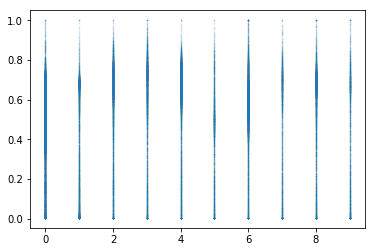

In [10]:
plt.scatter(actions,batt,s=0.2, alpha=0.05)

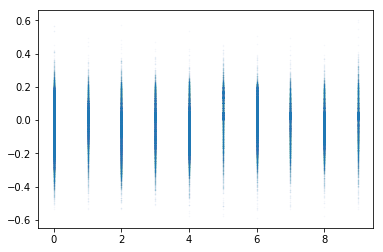

In [11]:
plt.scatter(actions,enp,s=0.2, alpha=0.05)

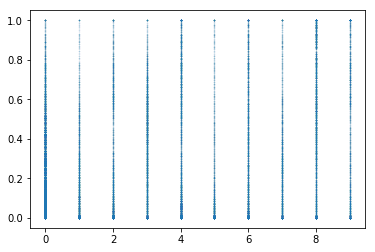

In [12]:
plt.scatter(actions,henergy,s=0.2, alpha=0.05)

Text(0,0.5,'Counts')

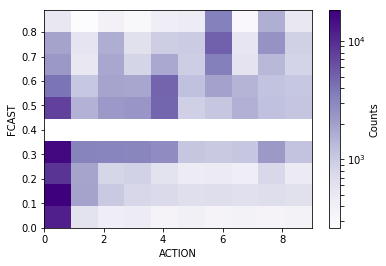

In [13]:

x=actions.tolist()
y=fcast
plt.hist2d(x, y, norm=LogNorm(), cmap=plt.cm.Purples)
plt.xlabel('ACTION')
plt.ylabel('FCAST')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

Text(0,0.5,'Counts')

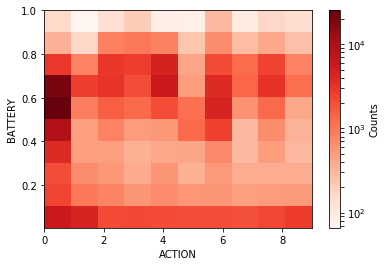

In [14]:
x=actions.tolist()
y=batt.tolist()
plt.hist2d(x, y, norm=LogNorm(),cmap=plt.cm.Reds)
plt.xlabel('ACTION')
plt.ylabel('BATTERY')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

Text(0,0.5,'Counts')

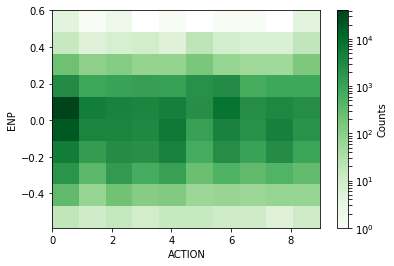

In [15]:
x=actions.tolist()
y=enp.tolist()
plt.hist2d(x, y, norm=LogNorm(),cmap=plt.cm.Greens)
plt.xlabel('ACTION')
plt.ylabel('ENP')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

Text(0,0.5,'Counts')

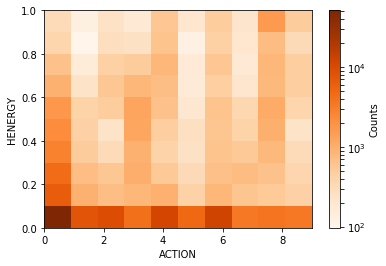

In [16]:
x=actions.tolist()
y=henergy.tolist()
plt.hist2d(x, y, norm=LogNorm(),cmap=plt.cm.Oranges)
plt.xlabel('ACTION')
plt.ylabel('HENERGY')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

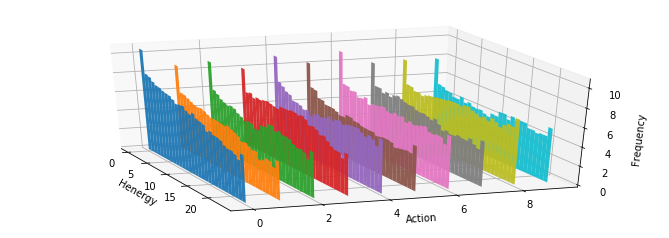

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=-0.75,right=0.75)
ax.view_init(elev=30, azim=-20)

nbins = 30
# for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
for a in range(0,10):
    ys = henergy[actions==9-a].tolist()
    hist, bins = np.histogram(ys,bins=nbins)
    xs = (bins[:-1] + bins[1:])/0.085
    ax.bar(xs, np.log(hist), zs=9-a, zdir='y', color=cmap((9-a)*2), alpha=0.95)

ax.set_xlabel('Henergy')
ax.set_ylabel('Action')
ax.set_zlabel('Frequency')

plt.show()

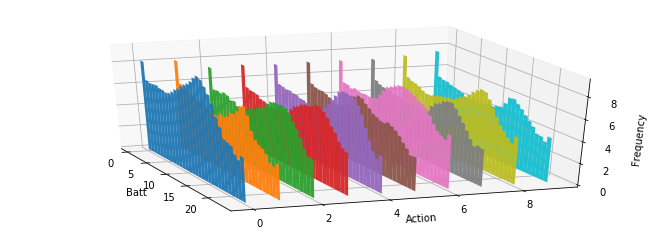

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=-0.75,right=0.75)
ax.view_init(elev=30, azim=-20)

nbins = 30
# for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
for a in range(0,10):
    ys = batt[actions==9-a].tolist()
    hist, bins = np.histogram(ys,bins=nbins)
    xs = (bins[:-1] + bins[1:])/0.085
    ax.bar(xs, np.log(hist), zs=9-a, zdir='y', color=cmap((9-a)*2), alpha=0.95)

ax.set_xlabel('Batt')
ax.set_ylabel('Action')
ax.set_zlabel('Frequency')

plt.show()

In [19]:
#calculated 4-way variance as cov(A,B,C,D) = E[ (A - E(A)) . (B - E(B)) . (C - E(C)) . (D - E(D)) ]
def var4(chunk):
    b_dev = chunk[:,0] - chunk[:,0].mean()
    e_dev = chunk[:,1] - chunk[:,1].mean()
    h_dev = chunk[:,2] - chunk[:,2].mean()
    f_dev = chunk[:,3] - chunk[:,3].mean()
    cov4 = np.mean(np.multiply(np.multiply(b_dev,e_dev),np.multiply(h_dev,f_dev)))
    cor4 = cov4/(b_dev.std()*e_dev.std()*h_dev.std()*f_dev.std())
    return [cov4, cor4]

In [20]:
chunklist = (np.split(states,175680/(8784)))
chunk_var = np.array([var4(i) for i in chunklist])

In [21]:
cov_trend = chunk_var[:,0]
cor_trend = -chunk_var[:,1]
y = np.arange(0,175680/8784)

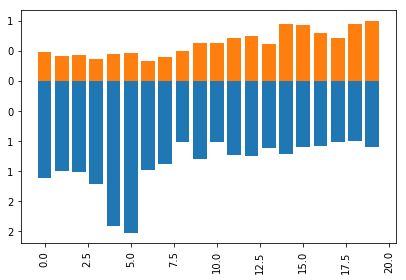

In [22]:
fig, ax = plt.subplots()
ax.bar(y, cov_trend/np.abs(cov_trend.max()))
ax.bar(y, cor_trend/np.abs(cor_trend.max()))

# Formatting x labels
plt.xticks(rotation=90)
plt.tight_layout()
# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
plt.show()

<BarContainer object of 20 artists>

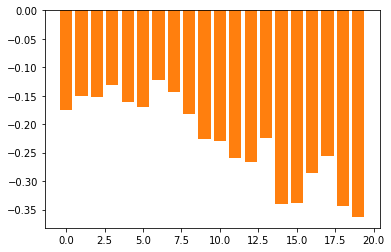

In [23]:
#plot how variance changes as exploration progresses each year
plt.bar(np.arange(0,175680/(8784)),cov_trend)
plt.bar(np.arange(0,175680/(8784)),-cor_trend)